In [132]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib

matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [133]:
df = pd.read_csv("daily_aqi.csv")
aqi = df

In [134]:
aqi.isnull().sum()

Unnamed: 0    0
Date          0
AQI           0
month         0
year          0
dtype: int64

In [135]:
aqi['Date'] = pd.to_datetime(aqi['Date'])
aqi = aqi.set_index('Date')
aqi_m = aqi.resample('MS').mean()

In [136]:
aqi_m['2017':]

,Unnamed: 0,AQI,month,year
Date,,,,
2017-01-01,4.373637e+06,35.996409,1.0,2017.0
2017-02-01,4.373682e+06,40.245020,2.0,2017.0
2017-03-01,4.373173e+06,37.845152,3.0,2017.0
2017-04-01,4.373183e+06,43.211370,4.0,2017.0
2017-05-01,4.373183e+06,50.011348,5.0,2017.0
...,...,...,...,...
2022-06-01,1.069790e+07,61.201780,6.0,2022.0
2022-07-01,1.069789e+07,45.626761,7.0,2022.0
2022-08-01,1.069805e+07,39.703264,8.0,2022.0


In [137]:
aqi_m.columns.to_list()

['Unnamed: 0', 'AQI', 'month', 'year']

In [138]:
aqi_m=aqi_m.drop(['Unnamed: 0', 'month', 'year'], axis=1)
aqi_m.dropna()

,AQI
Date,
1980-01-01,23.401818
1980-02-01,31.031955
1980-03-01,33.049904
1980-04-01,43.020619
1980-05-01,58.371534
...,...
2022-06-01,61.201780
2022-07-01,45.626761
2022-08-01,39.703264


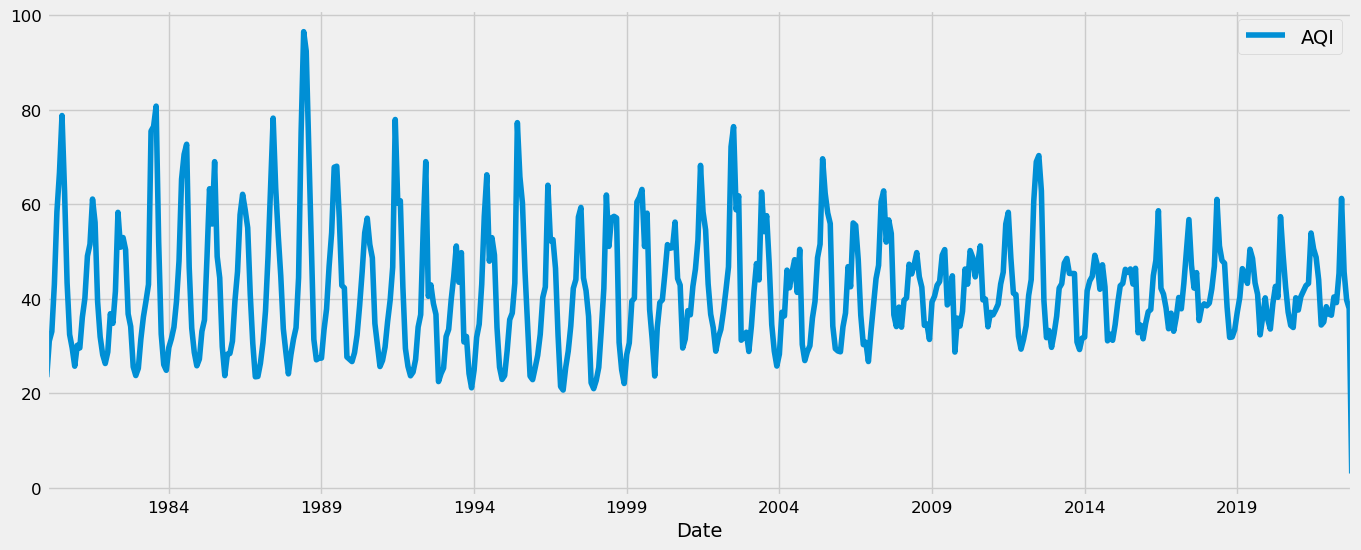

In [139]:
aqi_m.plot(figsize=(15, 6))
plt.show()

In [140]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [141]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

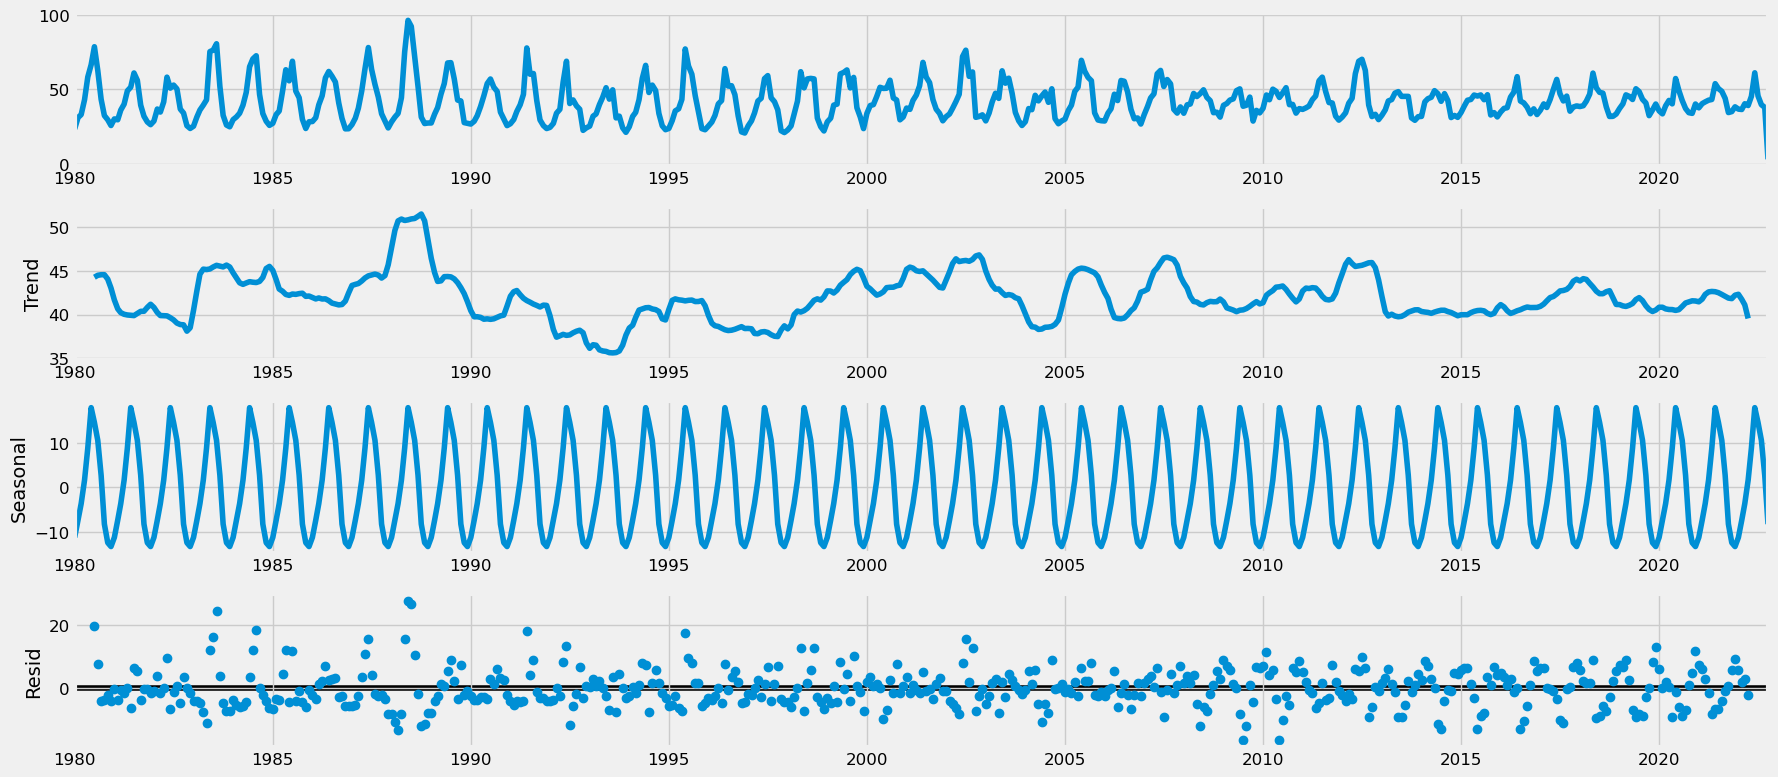

In [142]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8

decomposition = sm.tsa.seasonal_decompose(aqi_m, model='additive')
fig = decomposition.plot()
plt.show()

In [143]:
mod = sm.tsa.statespace.SARIMAX(aqi_m.AQI,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()

print(results.summary().tables[1])

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.19385D+00    |proj g|=  6.59440D-02

At iterate    5    f=  3.14112D+00    |proj g|=  5.56684D-02

At iterate   10    f=  3.12981D+00    |proj g|=  2.31455D-01

At iterate   15    f=  3.12648D+00    |proj g|=  1.00887D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     15     28      1     0     0   1.009D-04   3.126D+00
  F =   3.1264787718506133     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
        

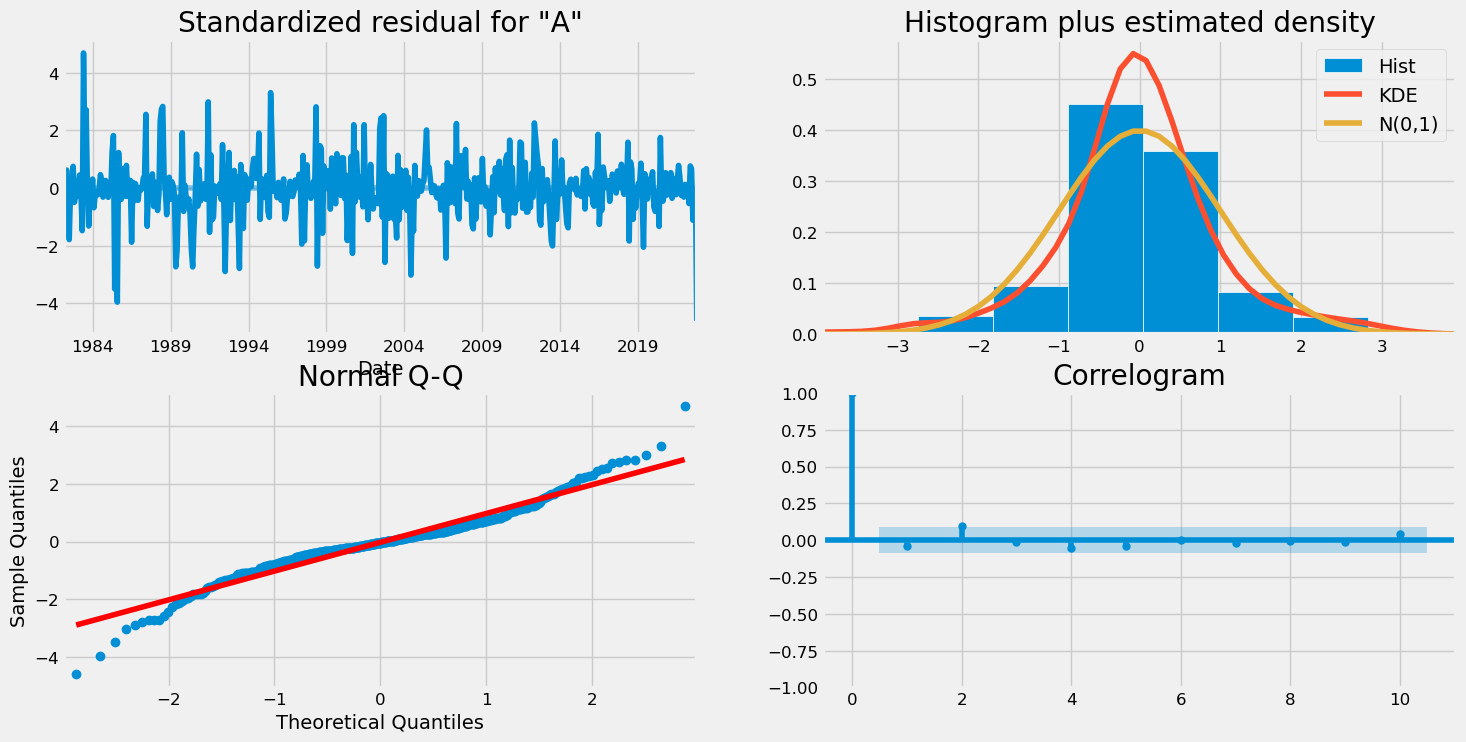

In [144]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

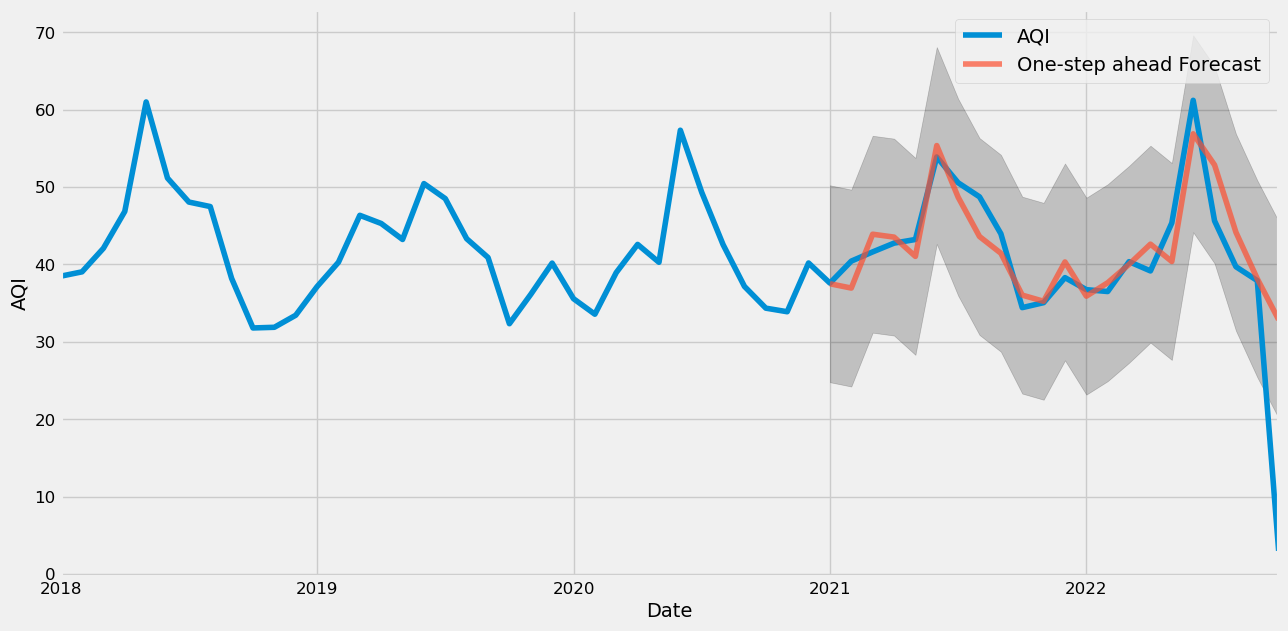

In [145]:
pred = results.get_prediction(start=pd.to_datetime('2021-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = aqi_m['2018':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('AQI')
plt.legend()

plt.show()

In [146]:
y_forecasted = pred.predicted_mean
y_truth = aqi_m['2017-01-01':]

mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 2021-01-01 00:00:00   NaN
2021-02-01 00:00:00   NaN
2021-03-01 00:00:00   NaN
2021-04-01 00:00:00   NaN
2021-05-01 00:00:00   NaN
2021-06-01 00:00:00   NaN
2021-07-01 00:00:00   NaN
2021-08-01 00:00:00   NaN
2021-09-01 00:00:00   NaN
2021-10-01 00:00:00   NaN
2021-11-01 00:00:00   NaN
2021-12-01 00:00:00   NaN
2022-01-01 00:00:00   NaN
2022-02-01 00:00:00   NaN
2022-03-01 00:00:00   NaN
2022-04-01 00:00:00   NaN
2022-05-01 00:00:00   NaN
2022-06-01 00:00:00   NaN
2022-07-01 00:00:00   NaN
2022-08-01 00:00:00   NaN
2022-09-01 00:00:00   NaN
2022-10-01 00:00:00   NaN
AQI                   NaN
dtype: float64


In [147]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 2021-01-01 00:00:00   NaN
2021-02-01 00:00:00   NaN
2021-03-01 00:00:00   NaN
2021-04-01 00:00:00   NaN
2021-05-01 00:00:00   NaN
2021-06-01 00:00:00   NaN
2021-07-01 00:00:00   NaN
2021-08-01 00:00:00   NaN
2021-09-01 00:00:00   NaN
2021-10-01 00:00:00   NaN
2021-11-01 00:00:00   NaN
2021-12-01 00:00:00   NaN
2022-01-01 00:00:00   NaN
2022-02-01 00:00:00   NaN
2022-03-01 00:00:00   NaN
2022-04-01 00:00:00   NaN
2022-05-01 00:00:00   NaN
2022-06-01 00:00:00   NaN
2022-07-01 00:00:00   NaN
2022-08-01 00:00:00   NaN
2022-09-01 00:00:00   NaN
2022-10-01 00:00:00   NaN
AQI                   NaN
dtype: float64


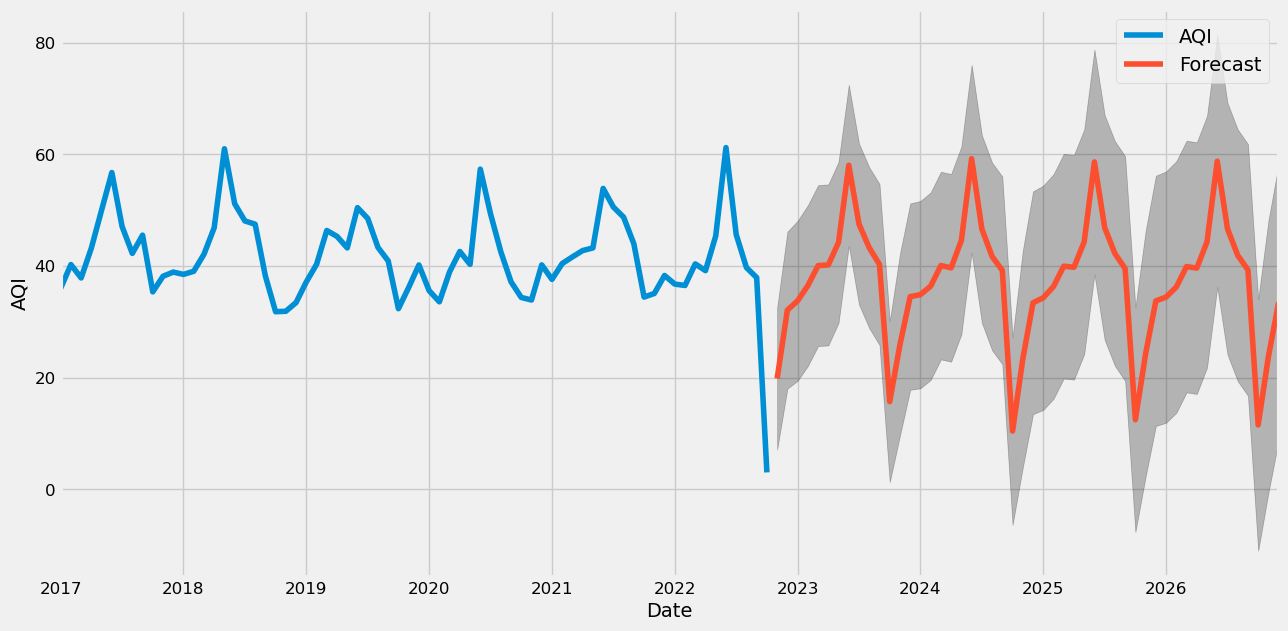

In [148]:
pred_uc = results.get_forecast(steps=50)
pred_ci = pred_uc.conf_int()

ax = aqi_m['2017':].plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('AQI')

plt.legend()
plt.show()